In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
DATA_DIR='20_newsgroups'
folders=sorted(os.listdir(os.path.join(DATA_DIR))) # os.listdir gives a list of all files in this path
folders

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
data={} 
for folder in folders:
    data[folder]=[]
    for file in os.listdir(os.path.join(DATA_DIR,folder)):
        with open(os.path.join(DATA_DIR,folder,file),encoding='latin-1') as opened_file:
            data[folder].append(opened_file.read())


In [4]:
from nltk.corpus import stopwords 
from string import punctuation 
punctuations=list(punctuation)
stopWords=stopwords.words('english')
stopWords+=punctuations 

In [5]:
stopWords+=['subject:','from:', 'date:', 'newsgroups:', 'message-id:', 'lines:', 'path:', 'organization:', 
            'would', 'writes:', 'references:', 'article', 'sender:', 'nntp-posting-host:', 'people', 
            'university', 'think', 'xref:', 'cantaloupe.srv.cs.cmu.edu', 'could', 'distribution:', 'first', 
            'anyone','world', 'really', 'since', 'right', 'believe', 'still', 
            "max>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'"]

In [6]:
vocab={}
for i in range(len(data)): 
    for doc in data[folders[i]]: 
        for word in doc.split(): 
            if word.lower() not in stopWords and len(word.lower()) >= 5:
                if word.lower() not in vocab:
                    vocab[word.lower()]=1
                else:
                    vocab[word.lower()]+=1


In [7]:
import operator
sorted_vocab=sorted(vocab.items(),key=operator.itemgetter(1),reverse=True)

In [8]:
# Choosing top 2000 vocab words as features
feature_list=[]
for key in sorted_vocab:
    feature_list.append(key[0])
feature_list=feature_list[0:2000] # K = 2000 (number of words in vocab)

In [9]:
Y=[] 
for i in range(len(data)):
    for doc in data[folders[i]]:
        Y.append(folders[i])
Y=np.array(Y)

In [10]:
df = pd.DataFrame(columns = feature_list)
for folder in folders:
    for file in os.listdir(os.path.join(DATA_DIR,folder)):
        df.loc[len(df)] = np.zeros(len(feature_list))
        with open(os.path.join(DATA_DIR,folder,file),encoding='latin-1') as opened_file:
            for word in opened_file.read().split():
                if word.lower() in feature_list:
                    df[word.lower()][len(df)-1] += 1 

In [11]:
X=df.values

In [21]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,random_state=0,test_size=0.3)

In [22]:
def fit(x_train,y_train):
    result={}
    result["total_data"]=len(y_train)
    class_labels=set(y_train)
    for current_label in class_labels:
        result[current_label]={}
        current_rows=(y_train==current_label)
        x_train_current=x_train[current_rows]
        y_train_current=y_train[current_rows]
        total_words=0
        for i in range(len(feature_list)):
            result[current_label][feature_list[i]]=x_train_current[:,i].sum()
            total_words+=x_train_current[:,i].sum()
        result[current_label]["total_count"]=total_words
    return result

In [23]:
def probability(x,dictionary,current_class):
    output=np.log(dictionary[current_class]["total_count"])-np.log(dictionary["total_data"])
    for i in range(len(feature_list)):
        current_word_count=dictionary[current_class][feature_list[i]]+1
        total_word_count=dictionary[current_class]["total_count"]+len(feature_list)
        current_word_probability=np.log(current_word_count)-np.log(total_word_count)
        for j in range(int(x[i])): # if the frequency of word in test data point is zero then we wont consider it.
            output+=current_word_probability
    return output

In [24]:
def predictSingleClass(x,dictionary):
    best_class=-1000
    best_prob=-1000
    firstRun=True
    possible_classes=dictionary.keys()
    for current_class in possible_classes:
        if current_class=="total_data":
            continue
        current_class_probability=probability(x,dictionary,current_class)
        if(firstRun==True or current_class_probability>best_prob):
            best_class=current_class
            best_prob=current_class_probability
        firstRun=False
    return best_class

In [25]:
def predict(X_test,dictionary):
    Y_pred=[]
    num = 0
    for x in X_test:
        Y_pred.append(predictSingleClass(x,dictionary))
    return Y_pred

In [26]:
dictionary=fit(x_train,y_train)

In [27]:
y_pred=predict(x_test,dictionary)

In [28]:
from sklearn.metrics import classification_report,confusion_matrix
cm=confusion_matrix(y_pred,y_test)
print(classification_report(y_pred,y_test))

                          precision    recall  f1-score   support

             alt.atheism       0.80      0.74      0.77       297
           comp.graphics       0.80      0.77      0.79       311
 comp.os.ms-windows.misc       0.86      0.84      0.85       317
comp.sys.ibm.pc.hardware       0.86      0.82      0.84       299
   comp.sys.mac.hardware       0.91      0.87      0.89       309
          comp.windows.x       0.90      0.90      0.90       294
            misc.forsale       0.82      0.85      0.83       293
               rec.autos       0.86      0.88      0.87       314
         rec.motorcycles       0.93      0.84      0.88       359
      rec.sport.baseball       0.97      0.93      0.95       321
        rec.sport.hockey       0.97      0.96      0.97       279
               sci.crypt       0.85      0.89      0.87       266
         sci.electronics       0.86      0.87      0.86       306
                 sci.med       0.84      0.91      0.87       275
         

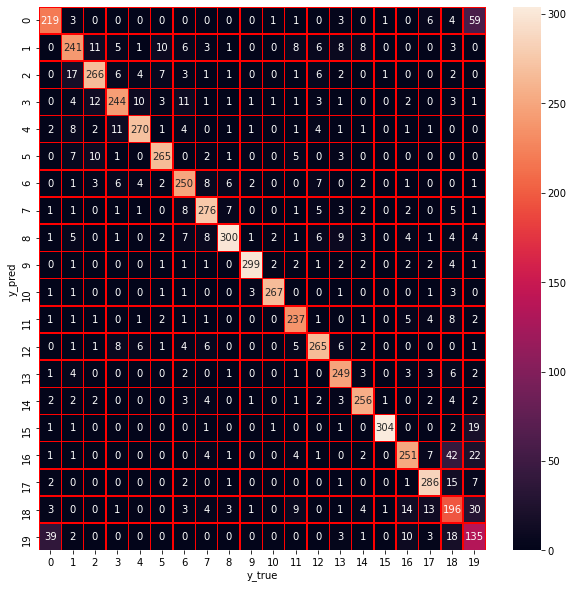

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax=plt.subplots(figsize=(10,10))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.ylabel("y_pred")
plt.xlabel("y_true")
plt.show()